<a href="https://colab.research.google.com/github/anissa762/goldfish/blob/main/goldfish2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Install necessary libraries
!pip install --upgrade optuna ta tensorflow torch torchvision
!pip install xgboost

# Import Libraries
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime, timedelta

# Machine Learning Libraries
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# For Technical Indicators
import ta

# For Optuna Hyperparameter Tuning
import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned

# XGBoost
import xgboost as xgb

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For saving/loading data
import pickle

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Define paths
DATA_PATH = '/content/drive/MyDrive/data/'  # Update this path based on your directory structure
STUDIES_DIR = os.path.join(DATA_PATH, 'optuna_studies')
STUDY_DB_PATH = os.path.join(STUDIES_DIR, 'optuna_study.db')  # SQLite database path
FORECASTS_PATH = os.path.join(DATA_PATH, 'stock_forecasts.pkl')
PERFORMANCE_PATH = os.path.join(DATA_PATH, 'model_performance.pkl')
BEST_PARAMS_PATH = os.path.join(DATA_PATH, 'best_params_dict.pkl')
ELECTION_DATA_PATH = '/content/drive/MyDrive/final_stock_rankings.csv'  # Update as necessary

# Create necessary directories if they don't exist
os.makedirs(STUDIES_DIR, exist_ok=True)

# Initialize dictionaries and lists to store data
best_params_dict = {}
stock_forecasts = {}
model_performance = []
inadequate_stocks = []

print("Paths are set and directories are created.")

Paths are set and directories are created.


In [16]:
# Initialize a dictionary to store DataFrames
stock_data = {}

# Feature Engineering Function
def add_technical_indicators(df):
    df = df.copy()

    # Moving Averages
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Relative Strength Index
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # Moving Average Convergence Divergence
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()

    # Volume Indicators
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()

    # On-Balance Volume
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()

    # Exponential Moving Averages
    df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
    df['EMA50'] = ta.trend.EMAIndicator(df['Close'], window=50).ema_indicator()

    # Drop initial rows with NaN values due to rolling calculations
    df.dropna(inplace=True)

    return df

# Load and preprocess each CSV file
csv_files = glob.glob(os.path.join(DATA_PATH, '*_data_cleaned.csv'))
print(f"Total CSV files found: {len(csv_files)}")

for file in csv_files:
    stock_name = os.path.basename(file).split('_')[0]
    df = pd.read_csv(file)

    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Sort by Date
    df = df.sort_values('Date')

    # Drop rows with any NA values
    df.dropna(inplace=True)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Add technical indicators
    df = add_technical_indicators(df)

    # Store in dictionary
    stock_data[stock_name] = df

print("Data loading and preprocessing completed.")

Total CSV files found: 260
Data loading and preprocessing completed.


In [17]:
# Load Election Impact Data
if os.path.exists(ELECTION_DATA_PATH):
    election_data = pd.read_csv(ELECTION_DATA_PATH)
    print("Loaded election impact data.")
else:
    election_data = pd.DataFrame()
    print("Election impact data not found.")

# Display the first few rows and columns of election impact data to understand its structure
if not election_data.empty:
    print("Election Impact Data Columns:", election_data.columns.tolist())
    display(election_data.head())
else:
    print("No election impact data to display.")

Loaded election impact data.
Election Impact Data Columns: ['Ticker', 'InverseCorr2016', 'InverseCorr2020', 'FinalScore']


,Ticker,InverseCorr2016,InverseCorr2020,FinalScore
0,WFC,0.167520,-0.035576,0.203096
1,EQT,0.068077,-0.114918,0.182995
2,K,0.074987,-0.091078,0.166065
3,HPE,0.126264,-0.036836,0.163100
4,BAC,0.099325,-0.062520,0.161845


In [18]:
# Merge 'FinalScore' into each stock's DataFrame
# Identify the correct column name for stock identifiers
stock_identifier_cols = ['Stock', 'Ticker', 'Symbol']

# Find which of these columns exists in election_data
existing_id_cols = [col for col in stock_identifier_cols if col in election_data.columns]

if not existing_id_cols:
    raise KeyError(f"None of the expected stock identifier columns {stock_identifier_cols} found in election_data.")
elif len(existing_id_cols) > 1:
    print(f"Multiple identifier columns found: {existing_id_cols}. Using the first one: '{existing_id_cols[0]}'.")
    id_col = existing_id_cols[0]
else:
    id_col = existing_id_cols[0]
    print(f"Using '{id_col}' as the stock identifier column for merging.")

# Define the default ElectionImpact value
DEFAULT_ELECTION_IMPACT = 0  # Represents 'no impact'

# Proceed to merge 'FinalScore' based on the identified stock identifier column
for stock in stock_data:
    # Retrieve the 'FinalScore' for the current stock
    score_series = election_data.loc[election_data[id_col] == stock, 'FinalScore']

    if not score_series.empty:
        election_impact = score_series.values[0]
        print(f"Assigned ElectionImpact for {stock}: {election_impact}")
    else:
        # If 'FinalScore' is not specified for the stock, assign the default impact value
        election_impact = DEFAULT_ELECTION_IMPACT
        print(f"No ElectionImpact specified for {stock}. Assigned default impact value: {0}")

    # Assign 'ElectionImpact' to the DataFrame
    stock_data[stock]['ElectionImpact'] = election_impact

Using 'Ticker' as the stock identifier column for merging.
Assigned ElectionImpact for XYL: -0.0020828702201409
Assigned ElectionImpact for WSM: 0.0654784830021114
Assigned ElectionImpact for WMB: -0.0337722429916873
Assigned ElectionImpact for WST: 0.0552518798394123
Assigned ElectionImpact for XOM: -0.0341210206746801
Assigned ElectionImpact for WY: 0.1239767103734074
Assigned ElectionImpact for WFC: 0.2030960160762678
Assigned ElectionImpact for WTW: 0.1126134281430669
Assigned ElectionImpact for WDC: 0.1162450134542883
Assigned ElectionImpact for ZBH: 0.0520346518539104
Assigned ElectionImpact for WBD: 0.0379008483854373
Assigned ElectionImpact for WELL: 0.0077327173983179
Assigned ElectionImpact for WDAY: 0.0792028281862628
Assigned ElectionImpact for VZ: 0.015503175866263
Assigned ElectionImpact for WAT: -0.0389472240845118
Assigned ElectionImpact for V: 0.0850969349459994
Assigned ElectionImpact for VEEV: -0.0049466658406312
Assigned ElectionImpact for URI: 0.1395217100292884
As

In [19]:
# Define the target window (e.g., 30 days)
TARGET_WINDOW_DAYS = 30

# Function to calculate percentage return over the target window
def calculate_future_return(df, window_days=30):
    df = df.copy()
    df['Future_Close'] = df['Close'].shift(-window_days)
    df['Target_Return'] = ((df['Future_Close'] - df['Close']) / df['Close']) * 100
    df.dropna(inplace=True)
    return df

# Apply the function to each stock's DataFrame
for stock in stock_data:
    df = stock_data[stock].copy()
    df = calculate_future_return(df, window_days=TARGET_WINDOW_DAYS)
    stock_data[stock] = df
    print(f"Processed Target_Return for {stock}.")

Processed Target_Return for XYL.
Processed Target_Return for WSM.
Processed Target_Return for WMB.
Processed Target_Return for WST.
Processed Target_Return for XOM.
Processed Target_Return for WY.
Processed Target_Return for WFC.
Processed Target_Return for WTW.
Processed Target_Return for WDC.
Processed Target_Return for ZBH.
Processed Target_Return for WBD.
Processed Target_Return for WELL.
Processed Target_Return for WDAY.
Processed Target_Return for VZ.
Processed Target_Return for WAT.
Processed Target_Return for V.
Processed Target_Return for VEEV.
Processed Target_Return for URI.
Processed Target_Return for USB.
Processed Target_Return for VRTX.
Processed Target_Return for TEAM.
Processed Target_Return for TRGP.
Processed Target_Return for TFC.
Processed Target_Return for TSLA.
Processed Target_Return for TRMB.
Processed Target_Return for UNH.
Processed Target_Return for SPGI.
Processed Target_Return for SYF.
Processed Target_Return for TT.
Processed Target_Return for UNP.
Proces

In [20]:
# Initialize lists to store training data
features_list = []
targets_list = []

# Define feature columns
feature_cols = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA10', 'MA50', 'RSI',
               'MACD', 'MACD_signal', 'MACD_diff', 'Bollinger_High', 'Bollinger_Low',
               'Volume_MA20', 'OBV', 'EMA10', 'EMA50', 'ElectionImpact']

# Iterate through each adequate stock and compile features and targets
for stock in stock_data:
    df = stock_data[stock].copy()

    # Check if sufficient data is present
    if len(df) < (TARGET_WINDOW_DAYS + 1):
        inadequate_stocks.append(stock)
        print(f"Stock {stock} has insufficient data. Marking as inadequate.")
        continue

    # Extract features and target
    features = df[feature_cols].values
    target = df['Target_Return'].values

    # Append to lists
    features_list.append(features)
    targets_list.append(target)

print(f"Total adequate stocks for modeling: {len(features_list)}")

Stock TEAM has insufficient data. Marking as inadequate.
Stock TWLO has insufficient data. Marking as inadequate.
Stock ALNY has insufficient data. Marking as inadequate.
Stock HUBS has insufficient data. Marking as inadequate.
Total adequate stocks for modeling: 256


In [21]:
# Combine all stocks' data into a single dataset
all_features = []
all_targets = []

for stock_idx in range(len(features_list)):
    stock_features = features_list[stock_idx]
    stock_targets = targets_list[stock_idx]
    all_features.append(stock_features)
    all_targets.append(stock_targets)

# Convert to NumPy arrays
X = np.vstack(all_features)
y = np.hstack(all_targets)

print(f"Combined Feature matrix shape: {X.shape}")
print(f"Combined Target vector shape: {y.shape}")

Combined Feature matrix shape: (551963, 18)
Combined Target vector shape: (551963,)


In [22]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Example: Using the last fold as the test set
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (459970, 18)
Testing set shape: (91993, 18)


In [23]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")

Feature scaling completed.


In [26]:
# Define the objective function for Optuna
def objective_xgb(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Initialize XGBoost regressor with current hyperparameters
    model = xgb.XGBRegressor(**param, use_label_encoder=False, seed=42)

    # Perform cross-validation
    cv_results = xgb.cv(
        dtrain=xgb.DMatrix(X_train_scaled, label=y_train),
        params=param,
        nfold=5,
        num_boost_round=1000,
        early_stopping_rounds=50,
        metrics='rmse',
        as_pandas=True,
        seed=42,
        verbose_eval=False
    )

    # Extract the best RMSE
    best_rmse = cv_results['test-rmse-mean'].min()
    return best_rmse

# Define the storage URL (SQLite database in Google Drive)
storage_url = f"sqlite:///{STUDY_DB_PATH}"

# Check if the study already exists
if os.path.exists(STUDY_DB_PATH):
    print("Loading existing Optuna study...")
    study = optuna.load_study(study_name='xgb_hyperparam_tuning', storage=storage_url)
else:
    print("Creating a new Optuna study...")
    study = optuna.create_study(study_name='xgb_hyperparam_tuning', direction='minimize', storage=storage_url, load_if_exists=True)

# Run the study
study.optimize(objective_xgb, n_trials=14, timeout=1)  # 100 trials or 60 minutes

print("Best hyperparameters found:")
print(study.best_params)
print(f"Best RMSE: {study.best_value}")

Loading existing Optuna study...


[I 2024-12-08 18:59:35,998] Trial 16 finished with value: 4.759348974435326 and parameters: {'n_estimators': 992, 'max_depth': 15, 'learning_rate': 0.09308013165642216, 'subsample': 0.9950235808878001, 'colsample_bytree': 0.5171995951138009, 'gamma': 0.013749979938569131, 'min_child_weight': 4}. Best is trial 16 with value: 4.759348974435326.


Best hyperparameters found:
{'n_estimators': 992, 'max_depth': 15, 'learning_rate': 0.09308013165642216, 'subsample': 0.9950235808878001, 'colsample_bytree': 0.5171995951138009, 'gamma': 0.013749979938569131, 'min_child_weight': 4}
Best RMSE: 4.759348974435326


In [27]:
# Retrieve best hyperparameters
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['verbosity'] = 0

# Initialize the final model
final_model = xgb.XGBRegressor(**best_params, use_label_encoder=False, seed=42)

# Train the model on the entire training set
final_model.fit(X_train_scaled, y_train)

print("Final model training completed.")

# Predict on the testing set
y_pred = final_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model RMSE on Test Set: {rmse:.4f}")
print(f"Final Model MAE on Test Set: {mae:.4f}")

Final model training completed.
Final Model RMSE on Test Set: 12.2446
Final Model MAE on Test Set: 8.9041


In [28]:
# Save the final model
model_path = os.path.join(DATA_PATH, 'final_xgb_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Final model saved to {model_path}.")

# Save the scaler
scaler_path = os.path.join(DATA_PATH, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}.")

Final model saved to /content/drive/MyDrive/data/final_xgb_model.pkl.
Scaler saved to /content/drive/MyDrive/data/scaler.pkl.


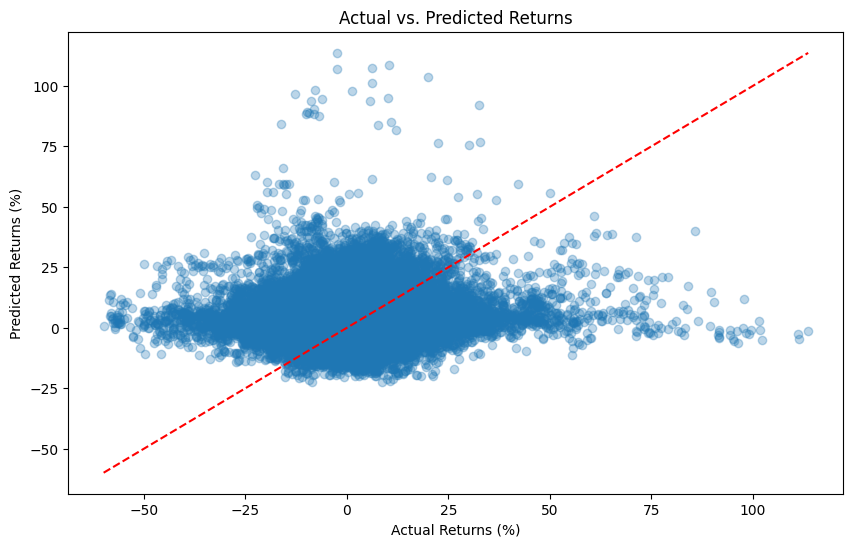

In [29]:
# Plot Actual vs Predicted Returns
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Returns (%)')
plt.ylabel('Predicted Returns (%)')
plt.title('Actual vs. Predicted Returns')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

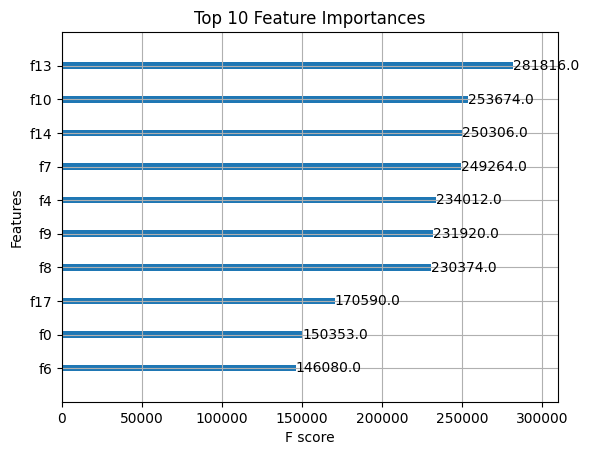

In [30]:
# Feature Importance from XGBoost
xgb.plot_importance(final_model, max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

In [31]:
# Initialize a list to store allocation candidates
allocation_candidates = []

for stock in stock_data:
    if stock in inadequate_stocks:
        continue  # Skip inadequate stocks

    df = stock_data[stock].copy()

    # Select the row corresponding to the latest data point (assumed to be the last row)
    latest_row = df.iloc[-1]

    # Extract features
    features = latest_row[feature_cols].values.reshape(1, -1)

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict return
    predicted_return = final_model.predict(features_scaled)[0]

    # Append to the list
    allocation_candidates.append({
        'Stock': stock,
        'Predicted_Return': round(predicted_return, 2)
    })

# Convert to DataFrame
allocation_df = pd.DataFrame(allocation_candidates)

# Sort by Predicted_Return in descending order
allocation_df.sort_values(by='Predicted_Return', ascending=False, inplace=True)
allocation_df.reset_index(drop=True, inplace=True)

# Display the top 10 candidates
print("Top 10 Stocks Based on Predicted Return:")
display(allocation_df.head(10))

Top 10 Stocks Based on Predicted Return:


,Stock,Predicted_Return
0,WDC,70.769997
1,TSLA,50.250000
2,AXON,46.209999
3,NFLX,25.139999
4,TRGP,24.830000
5,RJF,24.059999
6,EQT,23.750000
7,DFS,23.049999
8,MCK,22.209999
9,WFC,20.660000


In [32]:
# Define the number of top stocks to invest in
TOP_N = 1  # Adjust based on desired diversification

# Select top N stocks
top_stocks = allocation_df.head(TOP_N).copy()

# Allocate investment
total_investment = 30  # in GBP
top_stocks['Investment'] = total_investment / TOP_N

# Calculate Expected Profit
# Assuming Expected_Profit = Investment * (Predicted_Return / 100)
top_stocks['Expected_Profit'] = top_stocks['Investment'] * (top_stocks['Predicted_Return'] / 100)

# Round the numerical columns for better readability
top_stocks[['Investment', 'Expected_Profit']] = top_stocks[['Investment', 'Expected_Profit']].round(2)

# Display the allocation
print("### Investment Allocation ###\n")
display(top_stocks[['Stock', 'Investment', 'Predicted_Return', 'Expected_Profit']])

# Calculate total expected profit
total_expected_profit = top_stocks['Expected_Profit'].sum()

print(f"**Total Investment:** £{total_investment}")
print(f"**Total Expected Profit:** £{total_expected_profit}")

### Investment Allocation ###



,Stock,Investment,Predicted_Return,Expected_Profit
0,WDC,30.0,70.769997,21.23


**Total Investment:** £30
**Total Expected Profit:** £21.23


In [33]:
# Define the number of top stocks to invest in
TOP_N = 5  # Adjust based on desired diversification

# Select top N stocks
top_stocks = allocation_df.head(TOP_N).copy()

# Calculate the total predicted return of the top N stocks
total_predicted_return = top_stocks['Predicted_Return'].sum()

# Allocate investment proportionally based on predicted return
top_stocks['Weight'] = top_stocks['Predicted_Return'] / total_predicted_return
top_stocks['Investment'] = top_stocks['Weight'] * total_investment

# Calculate Expected Profit
top_stocks['Expected_Profit'] = top_stocks['Investment'] * (top_stocks['Predicted_Return'] / 100)

# Round the numerical columns for better readability
top_stocks[['Investment', 'Expected_Profit']] = top_stocks[['Investment', 'Expected_Profit']].round(2)

# Display the allocation
print("### Diversified Investment Allocation ###\n")
display(top_stocks[['Stock', 'Investment', 'Predicted_Return', 'Expected_Profit']])

# Calculate total expected profit
total_expected_profit = top_stocks['Expected_Profit'].sum()

print(f"**Total Investment:** £{total_investment}")
print(f"**Total Expected Profit:** £{total_expected_profit}")

### Diversified Investment Allocation ###



,Stock,Investment,Predicted_Return,Expected_Profit
0,WDC,9.77,70.769997,6.92
1,TSLA,6.94,50.250000,3.49
2,AXON,6.38,46.209999,2.95
3,NFLX,3.47,25.139999,0.87
4,TRGP,3.43,24.830000,0.85


**Total Investment:** £30
**Total Expected Profit:** £15.079999923706055


In [34]:
# Update the list of inadequate stocks to remove duplicates
inadequate_stocks = list(set(inadequate_stocks))

if inadequate_stocks:
    inadequate_df = pd.DataFrame({'Inadequate Stocks': inadequate_stocks})
    print("### Inadequate Stocks (Excluded from Analysis) ###")
    display(inadequate_df)
else:
    print("No Inadequate Stocks found.")

### Inadequate Stocks (Excluded from Analysis) ###


,Inadequate Stocks
0,HUBS
1,TWLO
2,ALNY
3,TEAM


In [35]:
# Final Summary
if TOP_N == 1:
    print("### Investment Strategy Summary ###\n")
    print(f"**Total Investment Available:** £{total_investment}\n")
    print(f"**Total Expected Profit:** £{total_expected_profit}\n")
    print("**Portfolio Allocation:**")
    display(top_stocks[['Stock', 'Investment', 'Predicted_Return', 'Expected_Profit']])
else:
    print("### Diversified Investment Strategy Summary ###\n")
    print(f"**Total Investment Available:** £{total_investment}\n")
    print(f"**Total Expected Profit:** £{total_expected_profit}\n")
    print("**Portfolio Allocation:**")
    display(top_stocks[['Stock', 'Investment', 'Predicted_Return', 'Expected_Profit']])

### Diversified Investment Strategy Summary ###

**Total Investment Available:** £30

**Total Expected Profit:** £15.079999923706055

**Portfolio Allocation:**


,Stock,Investment,Predicted_Return,Expected_Profit
0,WDC,9.77,70.769997,6.92
1,TSLA,6.94,50.250000,3.49
2,AXON,6.38,46.209999,2.95
3,NFLX,3.47,25.139999,0.87
4,TRGP,3.43,24.830000,0.85
